# L'esempio di addestramento e uso di una semplice rete neurale per leggere cifre scritte a mano
Luca Mari, marzo 2023

[i file di questa attività: [mnist.ipynb](mnist.ipynb), [mnistutils.py](mnistutils.py)]

**Obiettivi**: comprendere la struttura di una semplice rete neurale, il suo addestramento e il suo funzionamento, per come specificati in Python mediante un modulo di alto livello come `PyTorch`.  
**Precompetenze**: basi di Python.

(adattato da https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html)

Per eseguire questo notebook, supponiamo con VSCode, occorre:
* installare un interprete Python
* scaricare da https://code.visualstudio.com/download e installare VSCode
* eseguire VSCode e attivare le estensioni per Python e Jupyter
* ancora in VSCode:
    * creare una cartella di lavoro e renderla la cartella corrente
    * copiare nella cartella questo notebook e aprirlo
    * creare un ambiente virtuale locale Python (Select Kernel | Python Environments | Create Python Environment | Venv, e scegliere un interprete Python):
    * installare i moduli Python richiesti, eseguendo dal terminale:  
        `pip install torch torchvision torchsummary numpy matplotlib`

La rete che costruiremo dovrà imparare a riconoscere cifre scrite a mano, usando sia per l'addestramento sia per il funzionamento della rete [il dataset MNIST](https://en.wikipedia.org/wiki/MNIST_database), in cui ogni immagine, di 28x28 punti, contiene una cifra.

Dopo aver importato i moduli Python necessari, carichiamo le immagini del dataset MNIST, distinguendo tra training set e test set (la prima volta saranno scaricate dal web e copiate in una cartella locale).

In [1]:
from mnistutils import load_data, show_images, train_loop, test_loop, test_with_prob, test_loop_with_trace

train_data, test_data = load_data()

print(f"Numero di immagini nel training set: {len(train_data)}")
print(f"Numero di immagini nel test set: {len(test_data)}")

Numero di immagini nel training set: 60000
Numero di immagini nel test set: 10000


In questo modo possiamo mostrare qualche esempio delle immagini che contengono le cifre che vogliamo addestrare la rete a riconoscere.

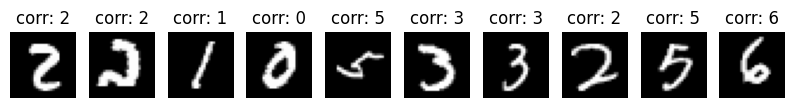

In [2]:
show_images(train_data)

La varietà e l'irregolarità di queste immagini suggeriscono che scrivere un programma "tradizionale", e dunque prima di tutto un algoritmo, potrebbe essere estremamente complesso. Cerchiamo dunque invece di risolvere il problema con la logica del *machine learning*, costruendo e poi addestrando una rete neurale artificiale.

Progettiamo la rete come un *MultiLayer Perceptron*, definendo una classe che eredita da `torch.Module` e inizializzando i layer della rete nel costruttore della classe:
* lo strato di input contiene 28*28 neuroni, dunque uno per ogni punto di un immagine, ognuno di essi connesso a ognuno dei neuroni del primo strato nascosto;
* il primo strato nascosto contiene 512 neuroni, ognuno di essi connesso a ognuno dei neuroni del secondo strato nascosto;
* il secondo strato nascosto contiene 512 neuroni, ognuno di essi connesso a ognuno dei neuroni dello strato di output;
* lo strato di output contiene 10 neuroni, uno per ogni possibile cifra riconoscibile.

La classe implementa nel metodo `forward` le operazioni che compie sui dati di input.

Creiamo quindi la rete instanziando la classe. A questo punto i parametri della rete sono inizializzati come valori casuali.

In [3]:
import torch
from torch import nn

class MLP_NN(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(   # Sequential() gestisce una successione di moduli
            nn.Linear(28*28, 512),      # Linear(x, y) è uno strato feed-forward fully connected con x input e y output
            nn.ReLU(),                  # ReLU() calcola la funzione di attivazione ReLu (rectified linear unit)
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = nn.Flatten()(x)             # Flatten() rende unidimensionale l'input, adattandolo così le immagini allo strato di input
        return self.network(x)
    
network = MLP_NN()

print(f"Questa è dunque una rete con {sum(p.numel() for p in network.parameters())} parametri.")

Questa è dunque una rete con 669706 parametri.


Possiamo chiedere una previsione a questa rete anche prima di addestrarla, ma ovviamente non ne otterremo nulla di utile, come si vede dal confronto tra la cifra prevista ("prev") e quella corretta ("corr") per un'immagine scelta a caso, in cui la cifra prevista è quella più probabile nella distribuzionee risultato dell'inferenza, cioè la moda della distribuzione. E infatti la distribuzione è praticamente uniforme, a indicare che la rete non è ancora in grado di riconoscere cifre.

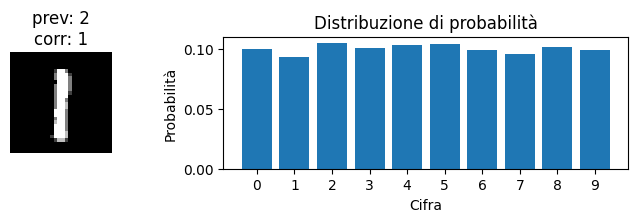

In [4]:
test_with_prob(test_data, network)

Specifichiamo allora come addestrare la rete, scegliendo gli iperparametri, la funzione di errore, e la funzione di ottimizzazione per la backpropagation.

In [5]:
learning_rate = 1e-3
batch_size = 50
num_batches = 500
epochs = 20

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate)

Addestriamo la rete in accordo a questi iperparametri e, contestualmente, mettiamola alla prova.

In [6]:
import time

start_time = time.time()
print("Epoca\tErrore\tAccuratezza")
for t in range(epochs):
    loss = train_loop(train_data, batch_size, num_batches, network, loss_fn, optimizer)
    correct = test_loop(test_data, batch_size, network)
    print(f"{t + 1}\t{loss:.3f}\t{100 * correct / batch_size:.1f}%")
end_time = time.time()

print(f"Processo completato, in {end_time - start_time:.2f} secondi")

Epoca	Errore	Accuratezza
1	2.293	18.0%
2	2.251	36.0%
3	2.237	48.0%
4	2.205	64.0%
5	2.156	62.0%
6	2.089	76.0%
7	1.988	70.0%
8	1.813	66.0%
9	1.738	64.0%
10	1.554	74.0%
11	1.367	78.0%
12	1.291	78.0%
13	1.152	84.0%
14	1.006	78.0%
15	0.890	80.0%
16	0.746	76.0%
17	0.640	94.0%
18	0.690	84.0%
19	0.599	86.0%
20	0.638	80.0%
Processo completato, in 31.08 secondi


A rete addestrata, valutiamo quantitativamente l'accuratezza delle previsioni che è in grado di fare.

In [10]:
batch_size = 1000
correct = test_loop(test_data, batch_size, network)
print(f"Accuratezza: {100*correct/batch_size:.1f}%")

Accuratezza: 83.3%


Valutiamo qualitativamente l'accuratezza delle previsioni, confrontando la cifra prevista ("prev") e quella corretta ("corr") per 10 immagini a caso.

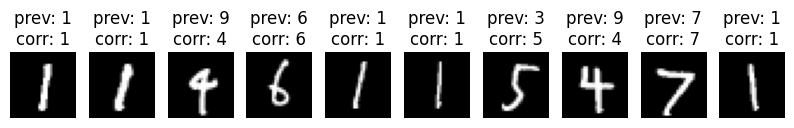

In [11]:
test_loop_with_trace(test_data, network)

Valutiamo il caso di una singola immagine, confrontando la cifra prevista ("prev") e quella corretta ("corr"), e visualizziamo la distribuzione di probabilità risultato dell'inferenza, da cui si sceglie la cifra prevista come quella più probabile.

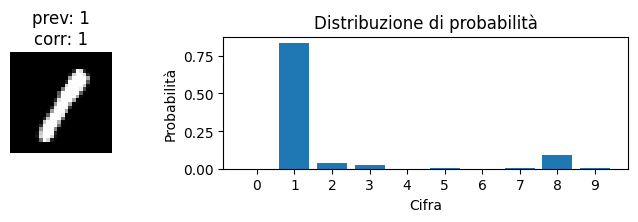

In [12]:
test_with_prob(test_data, network)

Ovviamente si potrebbe raffinare questo metodo di decisione, per esempio per non proporre alcuna previsione, e quindi dichiarare il caso dubbio, se la probabilità della moda non è abbastanza grande o la differenza fra le due probabilità più grandi della distribuzione non è abbastanza grande.

In [13]:

from torch.utils.data import DataLoader
network.eval()                              # metti in modalità di test
dataloader = iter(DataLoader(test_data, batch_size=batch_size, shuffle=True))   # crea un iteratore sul test set

with torch.no_grad():                       # non calcolare i gradienti
    X, y = next(dataloader)                 # prendi un batch di immagini ed etichette
    logits = network(X)                     # calcola le previsioni
pred_prob = nn.Softmax(dim=1)(logits)       # converti le previsioni in distribuzioni di probabilità

y_pred = pred_prob.argmax(1)
corr_pred = torch.eq(y_pred, y)
print("*** Risultati del test senza aggiustamento ***")
print(f"Accuratezza: {100 * corr_pred.sum().item() / batch_size:.1f}%")
print(f"Errore: {100 * (batch_size - corr_pred.sum().item()) / batch_size:.1f}%")

min_mode_prob = 0.3                         # probabilità minima per considerare una previsione corretta
min_diff_prob = 0.2                         # differenza minima tra le due probabilità più alte per considerare una previsione corretta
two_max_prob = torch.topk(pred_prob, 2).values
suff_high_prob = two_max_prob[:,0] > min_mode_prob
suff_diff_prob = (two_max_prob[:,0] - two_max_prob[:,1]) > min_diff_prob
suff_quality = suff_high_prob * suff_diff_prob
adj_corr_pred = corr_pred * suff_quality
doubtful_pred = torch.logical_not(suff_quality)
print("\n*** Risultati del test con aggiustamento ***")
print(f"(probabilità minima per considerare una previsione corretta: {min_mode_prob})")
print(f"(differenza minima tra le due probabilità più alte per considerare una previsione corretta: {min_diff_prob})")
print(f"Accuratezza: {100 * adj_corr_pred.sum().item() / batch_size:.1f}%")
print(f"Previsioni sospese perché dubbie: {100 * doubtful_pred.sum().item() / batch_size:.1f}%")
print(f"Errore: {100 * (suff_quality * torch.logical_not(corr_pred)).sum().item() / batch_size:.1f}%")

*** Risultati del test senza aggiustamento ***
Accuratezza: 85.6%
Errore: 14.4%

*** Risultati del test con aggiustamento ***
(probabilità minima per considerare una previsione corretta: 0.3)
(differenza minima tra le due probabilità più alte per considerare una previsione corretta: 0.2)
Accuratezza: 71.1%
Previsioni sospese perché dubbie: 24.6%
Errore: 4.3%


Come si vede, questo aggiustamento riduce l'accuratezza ma anche l'errore della previsione. Ecco qualche esempio.

Esempi di immagini per cui non si è sicuri della previsione:


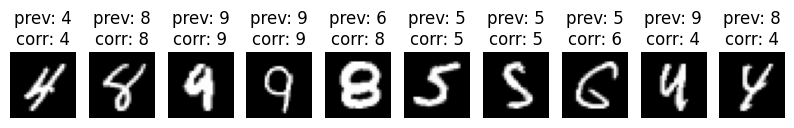

Esempi di immagini per cui la previsione è sbagliata:


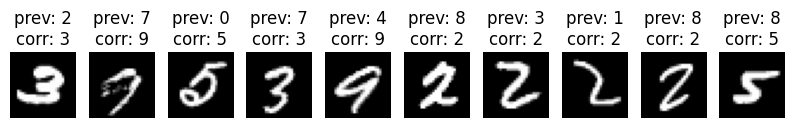

In [14]:
doubtful_data = [(X[i], y[i]) for i in range(batch_size) if doubtful_pred[i]]
print("Esempi di immagini per cui non si è sicuri della previsione:")
test_loop_with_trace(doubtful_data, network)

wrong_pred = [(X[i], y[i]) for i in range(batch_size) if (suff_quality * torch.logical_not(corr_pred))[i]]
print("Esempi di immagini per cui la previsione è sbagliata:")
test_loop_with_trace(wrong_pred, network)


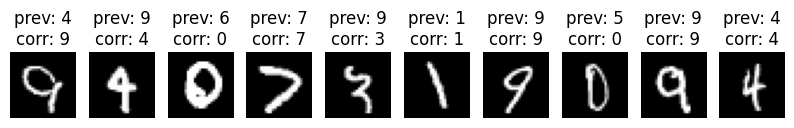